In [5]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()   #Select the big dataset.zip file here

#Get the uploaded filename
zip_filename = list(uploaded.keys())[0]

#Extract
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")




Saving archive.zip to archive.zip


['augmentated image']

In [19]:
#Show what got extracted
print("Top-level folders inside /content/dataset:\n", os.listdir("/content/dataset"))

for root, dirs, files in os.walk("/content/dataset"):
    print("Folder:", root)
    print("Subfolders:", dirs[:10])
    break


Top-level folders inside /content/dataset:
 ['augmentated image']
Folder: /content/dataset
Subfolders: ['augmentated image']


In [20]:
dataset_dir = "/content/dataset/augmentated image"
benign_dir = os.path.join(dataset_dir, "benign")
malignant_dir = os.path.join(dataset_dir, "malignant")

print("Benign count:", len(os.listdir(benign_dir)))
print("Malignant count:", len(os.listdir(malignant_dir)))


Benign count: 2735
Malignant count: 5730


In [25]:
import random
from shutil import copy2

#extracted dataset
dataset_dir = "/content/dataset/augmentated image"
benign_dir = os.path.join(dataset_dir, "benign")
malignant_dir = os.path.join(dataset_dir, "malignant")

print("Total Benign images:", len(os.listdir(benign_dir)))
print("Total Malignant images:", len(os.listdir(malignant_dir)))

#Choose how many you want
benign_count = 250
malignant_count = 250

#Randomly pick images
random.seed(42)
benign_sample = random.sample(os.listdir(benign_dir), benign_count)
malignant_sample = random.sample(os.listdir(malignant_dir), malignant_count)

#Create subset folders
subset_dir = "/content/subset500"
benign_subset_dir = os.path.join(subset_dir, "benign")
malignant_subset_dir = os.path.join(subset_dir, "malignant")

os.makedirs(benign_subset_dir, exist_ok=True)
os.makedirs(malignant_subset_dir, exist_ok=True)

#Copy files to subset
for fname in benign_sample:
    copy2(os.path.join(benign_dir, fname), benign_subset_dir)

for fname in malignant_sample:
    copy2(os.path.join(malignant_dir, fname), malignant_subset_dir)

print(f"✅ Subset created with {benign_count + malignant_count} images at:", subset_dir)


Total Benign images: 2735
Total Malignant images: 5730
✅ Subset created with 500 images at: /content/subset500


In [26]:
import shutil

#Paths
subset_dir = "/content/subset500"
train_dir = "/content/data_split/train"
val_dir = "/content/data_split/val"

#Ensure directories exist
for d in [train_dir, val_dir]:
    os.makedirs(os.path.join(d, "benign"), exist_ok=True)
    os.makedirs(os.path.join(d, "malignant"), exist_ok=True)

#split
def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    for category in ["benign", "malignant"]:
        src_folder = os.path.join(source_dir, category)
        images = os.listdir(src_folder)
        random.shuffle(images)

        split_point = int(len(images) * split_ratio)
        train_files = images[:split_point]
        val_files = images[split_point:]

        #Copy training files
        for file in train_files:
            shutil.copy(os.path.join(src_folder, file),
                        os.path.join(train_dir, category, file))

        #Copy validation files
        for file in val_files:
            shutil.copy(os.path.join(src_folder, file),
                        os.path.join(val_dir, category, file))

#Perform the split
split_data(subset_dir, train_dir, val_dir, split_ratio=0.8)

print("✅ Data split completed.")
print("Training benign images:", len(os.listdir(os.path.join(train_dir, "benign"))))
print("Training malignant images:", len(os.listdir(os.path.join(train_dir, "malignant"))))
print("Validation benign images:", len(os.listdir(os.path.join(val_dir, "benign"))))
print("Validation malignant images:", len(os.listdir(os.path.join(val_dir, "malignant"))))


✅ Data split completed.
Training benign images: 200
Training malignant images: 200
Validation benign images: 50
Validation malignant images: 50


In [27]:
import numpy as np
import cv2
from tqdm import tqdm

#Define size
IMG_SIZE = (128, 128)

#Paths
train_dir = "/content/subset800/train"
val_dir = "/content/subset800/val"

#Function to load, resize, normalize images
def load_and_preprocess_images(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  #['benign', 'malignant']

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)       #resize to 128x128
                img = img.astype("float32") / 255.0   #normalize [0,1]
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

#Load train and validation sets
X_train, y_train = load_and_preprocess_images(train_dir)
X_val, y_val = load_and_preprocess_images(val_dir)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Processing malignant: 100%|██████████| 50/50 [00:00<00:00, 2165.25it/s]

Training set: (400, 128, 128, 3) (400,)
Validation set: (100, 128, 128, 3) (100,)


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

#CNN
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),   #Input layer

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.5471 - loss: 0.7900 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5821 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.7011
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5384 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4898 - loss: 0.6933 - val_accuracy: 0.4800 - val_loss: 0.6927
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6087 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5392 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4872 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5110 - loss: 0.6902 - val_accuracy: 0.5700 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5853 - loss: 0.6587
✅ Validation Loss: 0.6842
✅ Validation Accuracy: 0.5100


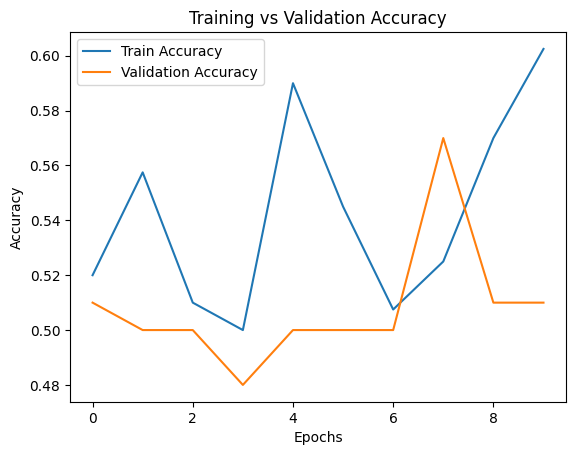

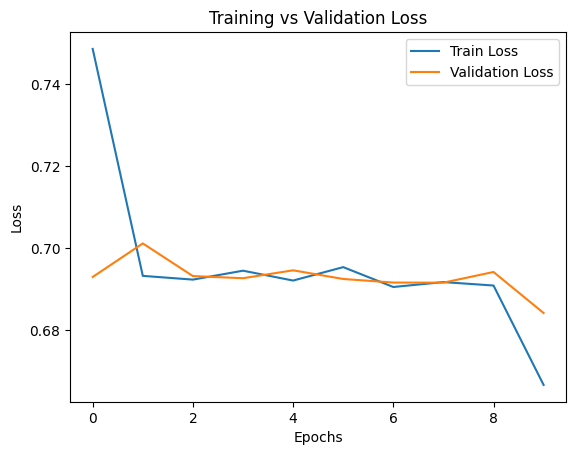

In [30]:
#Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"✅ Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

#Plot training history (loss & accuracy)
import matplotlib.pyplot as plt

#Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

#Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.4930 - loss: 0.8532 - val_accuracy: 0.5400 - val_loss: 0.6796
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6018 - loss: 0.6667 - val_accuracy: 0.6400 - val_loss: 0.6374
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7115 - loss: 0.5892 - val_accuracy: 0.6400 - val_loss: 0.6271
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7169 - loss: 0.5446 - val_accuracy: 0.6800 - val_loss: 0.6046
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8121 - loss: 0.4712 - val_accuracy: 0.6300 - val_loss: 0.6331
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.7769 - loss: 0.4786 - val_accuracy: 0.7300 - val_loss: 0.5803
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8457 - loss: 0.3978 - val_accuracy: 0.7000 - val_loss: 0.5715
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8806 - loss: 0.3339 - val_accuracy: 0.7300 - val_los

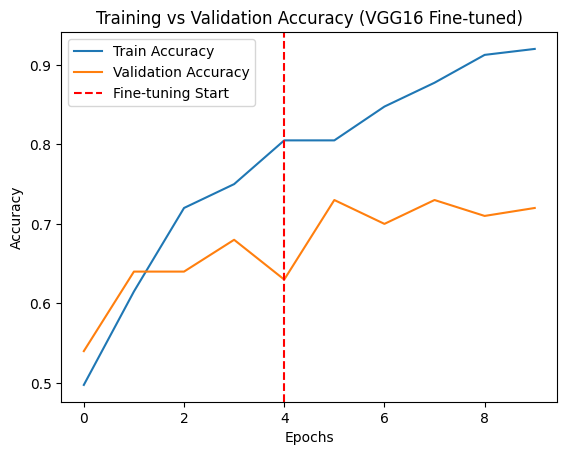

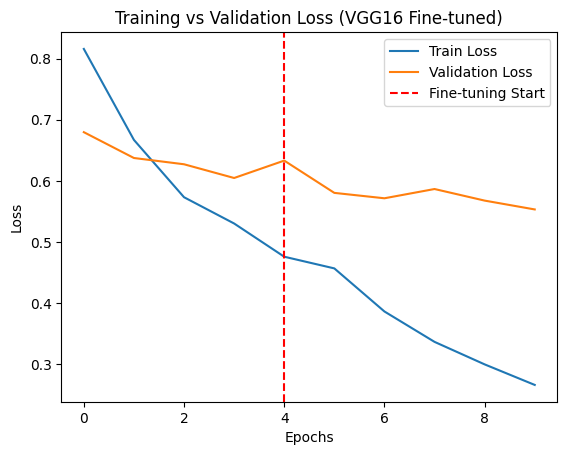

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

#Add classifier
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Train dense layers
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

for layer in base_model.layers[-4:]:  # unfreeze last 4 conv layers
    layer.trainable = True

#Recompile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#training
history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

#Merge histories for plotting
history = {}
for k in history1.history.keys():
    history[k] = history1.history[k] + history2.history[k]

#Evaluate
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"✅ Validation Loss after Fine-tuning: {val_loss:.4f}")
print(f"✅ Validation Accuracy after Fine-tuning: {val_accuracy:.4f}")

#Plot Accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label="Fine-tuning Start")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (VGG16 Fine-tuned)')
plt.legend()
plt.show()

#Plot Loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label="Fine-tuning Start")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (VGG16 Fine-tuned)')
plt.legend()
plt.show()
